<a href="https://colab.research.google.com/github/JanaSchwarzerova/SAPCDAMP/blob/main/SemiAutomated_pipeline_py_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Semi-automated pipeline using concept drift analysis for improving metabolomics predictions**


> Given the tremendous increase in optimized prediction methods and the availability of big data in metabolomics, it is important to focus on appropriate implementation and supplementation of techniques that fit with biological assumptions. This ensures that real-world diagnosis of early symptoms is facilitated.

> One of the most challenging scenarios in predictive data analysis is prediction based on data that may be influenced by a third factor that does not enter directly into the predictive analysis, the so-called confounding factor. The detection and subsequent correction of confounding factors aids in the accuracy of prediction models and so facilitate the diagnosis of early symptoms with the elimination of false negatives results that may contribute to diagnostic errors in medicine.

> Here we presents a new (semi-automated) implementation of concept drift analysis based on biological knowledge, and information described real-world to improve the accuracy of prediction methods. We also determined possible confounding factors based on biological assumptions confirmed by the detected concept drift. These confounding factors were used in the correction of the prediction algorithms to improve the accuracy of the prediction models.




---






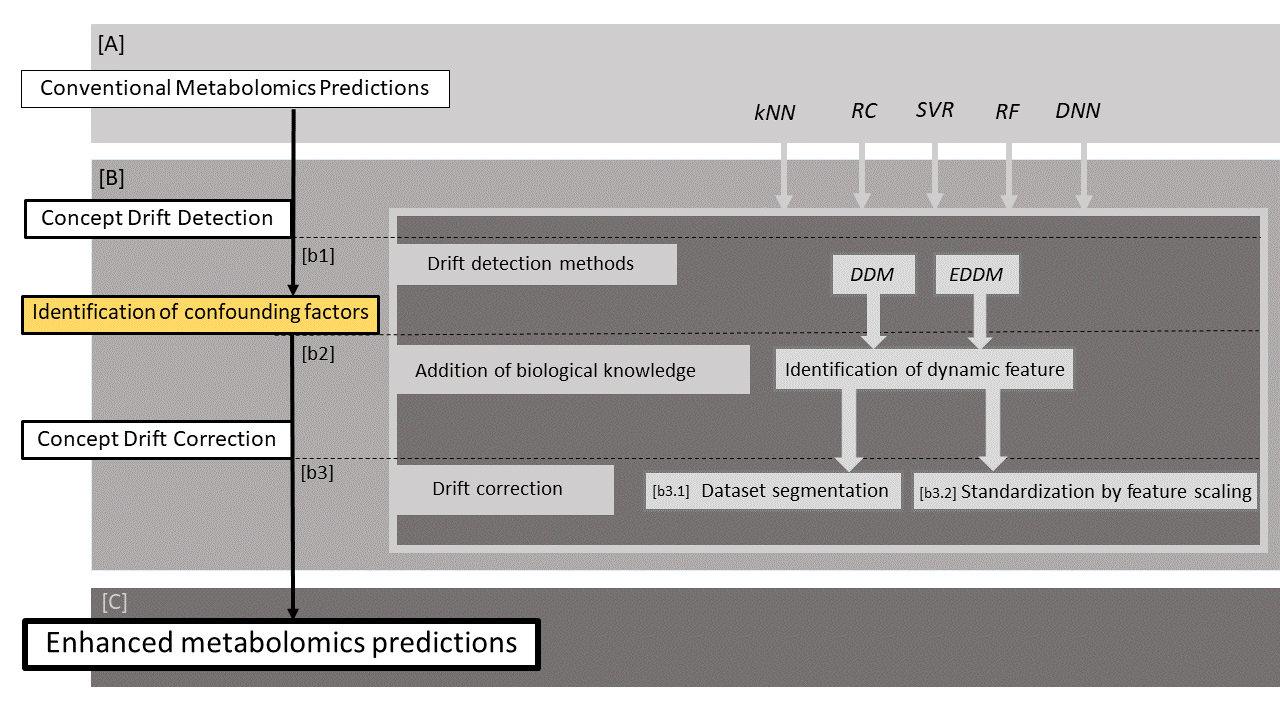

**Installation required packages and repositories**

In [ ]:
!pip install pip==21.3.1
!pip install scikit-multiflow
!pip install scikeras
!pip install tensorflow

!pip install --upgrade scikit-learn keras tensorflow

In [ ]:
import math
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Model Selection and Validation
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_validate, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# Drift Detection (for streaming data)
from skmultiflow.drift_detection.ddm import DDM
from skmultiflow.drift_detection.eddm import EDDM

# Metrics
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

# Pipeline
from sklearn.pipeline import make_pipeline


Connecting to Google Disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Loading dataset**


> Metabolite unification nomenclature was performed for GM (training and testing) and CSF (validation) and CML (validation) data:

1] GM data
> Chu,X. et al. (2021) Integration of metabolomics, genomics, and immune phenotypes reveals the causal roles of metabolites in disease. Genome Biol, 22.

2] CSF data
> Li,K. et al. (2022) Cerebrospinal fluid and plasma metabolomics of acute endurance exercise. FASEB Journal, 36.

3] CML data
> Karlíková, R., et al. (2016) Metabolite profiling of the plasma and leukocytes of chronic myeloid leukemia patients. Journal of proteome research, 15.

Missing values were filled with half of the minimum value, and outliers were removed using COVAIN:

> https://mosys.univie.ac.at/resources/software/


In the next cell 'Loading data', you can set your own path - to your own data:

In [ ]:
#_______________________________________________________________________________
#Loading data
#_______________________________________________________________________________
#

# Here you can put yourself working directory:
# url = ...

#_______________________________________________________________________________
# Our example data / you can find in github "example data" or supplementary
# materials

# data from study Chu et al. /Table S1
url_Chu_et_al = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/data_Chu_rev_gender.csv'
# data from study Li et al. /Table S2
url_Li_et_al = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/data_Li_rev_gender.csv'
# data from study Karlikova et al. /Table S3
url_Kar_et_al = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/data_Kar_rev_gender.csv'

In [ ]:
data_Chu = pd.read_csv(url_Chu_et_al, delimiter=',')
data_Li = pd.read_csv(url_Li_et_al, delimiter=',')
data_Kar = pd.read_csv(url_Kar_et_al, delimiter=',')


**Pre-process part**

First, load the cell with different methods for the function to apply scaling - and then, when you load the next cell, you will only write which scaling you will use.

In [ ]:
# Define the function to apply scaling
def apply_scaling(data, method):
    if method == "Centering":
        # Centering (subtract the mean for each column)
        return data.apply(lambda x: x - x.mean(), axis=0)

    elif method == "Autoscaling":
        # Standardization (subtract the mean and divide by the standard deviation)
        scaler = StandardScaler()
        return pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    elif method == "Range Scaling":
        # Min-Max scaling (scale to the range [0, 1])
        scaler = MinMaxScaler()
        return pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    elif method == "Pareto Scaling":
        # Pareto scaling (subtract the mean and divide by the standard deviation, then multiply by a factor of 2)
        return (data - data.mean()) / (data.std() * 2)

    elif method == "Vast Scaling":
        # Vast scaling (subtract the mean and divide by the standard deviation, then multiply by a factor of 10)
        return (data - data.mean()) / (data.std() * 10)

    elif method == "Level Scaling":
        # Level scaling (divide by the mean)
        return data / data.mean()

    elif method == "Log Transformation":
        # Logarithmic transformation (only for values > 0)
        data_log = data.copy()
        data_log[data_log <= 0] = np.nan  # Set zeros or negative values to NaN
        return np.log(data_log)

    elif method == "Power Transformation":
        # Power Transformation (Box-Cox)
        pt = PowerTransformer()
        return pd.DataFrame(pt.fit_transform(data), columns=data.columns)

    return data

# Function to load datasets
def load_and_clean_data(url):
    data = pd.read_csv(url)
    data = data.iloc[1:, :]  # Skip the first row, assuming it’s an undesired header
    data = data.drop(data.columns[-2], axis=1)  # Drop the second-to-last column
    return data

In [ ]:
# Ask the user for the scaling method
scaling_method = input("Enter the scaling method (Centering, Autoscaling, Range Scaling, Pareto Scaling, Vast Scaling, Level Scaling, Log Transformation, Power Transformation): ")

In [ ]:
# Apply scaling to all three datasets
data_Chu_without_last_column = data_Chu.iloc[:, :-1]
scaled_data_Chu = apply_scaling(data_Chu_without_last_column, scaling_method)
last_column_Chu = data_Chu.iloc[:, -1]
scaled_data_Chu = pd.concat([scaled_data_Chu, last_column_Chu], axis=1)

data_Li_without_last_column = data_Li.iloc[:, :-1]
scaled_data_Li = apply_scaling(data_Li_without_last_column, scaling_method)
last_column_Li = data_Li.iloc[:, -1]
scaled_data_Li = pd.concat([scaled_data_Li, last_column_Li], axis=1)


data_Kar_without_last_column = data_Kar.iloc[:, :-1]
scaled_data_Kar = apply_scaling(data_Kar_without_last_column, scaling_method)
last_column_Kar = data_Kar.iloc[:, -1]
scaled_data_Kar = pd.concat([scaled_data_Kar, last_column_Kar], axis=1)

# **[A] Conventional metabolomics prediction**

Various prediction approaches are implemented here:

1.   k-Nearest Neighbors (kNN) Classifier
2.   Ridge Classifier (RC)
3.   SVR Classifier (Support Vector machine Regression)
4.   RF Classifier (Random Forest)
5.   DNN Classifier (Deep Neural Network)





# **1. kNN Classifier** (KNeighborsClassifier)

The k-Nearest Neighbors (kNN) Classifier is a simple, instance-based learning algorithm that can be used for classification tasks. It works by finding the k nearest neighbors to a given point and assigning a label based on the majority vote of these neighbors.

This code applies the k-Nearest Neighbors (kNN) Classifier to a dataset and evaluates its performance.

***Data Preprocessing:***

The data is loaded into a pandas DataFrame and is cleaned using the clean_dataset function. This function:
Removes any rows with missing values (NaN).
Ensures that no rows contain invalid values such as NaN, inf, or -inf.
Converts all columns to float64 type to ensure consistency in numerical data for modeling.

***Data Splitting:***

The dataset is divided into features (met_X) and the target label (met_y). In this case, the target label is gender.
The data is then split into training and testing sets using the train_test_split function, with 80% of the data used for training and 20% for testing.

***Model Training:***

The KNeighborsClassifier is initialized with n_neighbors=15, meaning it will consider the 15 nearest neighbors for classification.
The model is trained using the training data (met_train_X and met_train_y).
The make_pipeline function is used to create a pipeline that applies preprocessing steps before training:
SimpleImputer() handles missing values in the dataset.
OneHotEncoder(handle_unknown='ignore') encodes categorical variables into a format suitable for the model (though in this case, it may not be necessary depending on the dataset).

Finally, the KNeighborsClassifier is used to perform the classification task.

***Prediction:***

After training, the model is used to predict the target label (gender) on the test data (met_test_X).
The accuracy of the model is evaluated using the .score() method, which provides the proportion of correct predictions on the test set.
Model Evaluation:

The model is evaluated further using cross-validation (cross_val_score), which splits the dataset into 10 subsets, trains on 9 of them, and tests on the remaining one. This process is repeated 10 times, and the model’s performance is averaged.
The mean accuracy and standard deviation are printed to evaluate how well the model is performing.
The classification_report function is used to generate a detailed report of precision, recall, F1-score, and accuracy for each class (in this case, for the gender label).

In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================

# Convert the scaled data into a DataFrame:
# data_frame = pd.DataFrame(data_Chu)
data_frame = pd.DataFrame(scaled_data_Chu)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any of the specified invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame, ensuring the data type is float64
    return df[indices_to_keep].astype(np.float64)  # changed data_frame to df

# Clean the data
data_frame = clean_dataset(data_frame)

# Splitting the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Split the data into training and testing sets (80% train, 20% test)
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(met_X, met_y, test_size=0.2, random_state=42)

# Create a pipeline for the kNN classifier with data preprocessing steps
model_kNN = make_pipeline(
    SimpleImputer(),  # Impute missing values in the data
    OneHotEncoder(handle_unknown='ignore'),  # Encode categorical features (ignore unknown values)
    KNeighborsClassifier(n_neighbors=15)  # kNN classifier with 15 neighbors
)

# Train the model using the training data
model_kNN.fit(met_train_X, met_train_y)

# Make predictions on the test set
predicted_kNN = model_kNN.predict(met_test_X)

# Print the accuracy of the model on the test data
print(model_kNN.score(met_test_X, met_test_y))

# Initialize and train the kNN classifier again, without the pipeline
model_kNN = KNeighborsClassifier(n_neighbors=15)
model_kNN.fit(met_train_X, met_train_y)

# Make predictions again with the second model
predicted_kNN = model_kNN.predict(met_test_X)

# Print the accuracy of the second kNN model
print(model_kNN.score(met_test_X, met_test_y))

# Model evaluation using cross-validation (10-fold cross-validation)
score = cross_val_score(model_kNN, met_test_X, met_test_y, cv=10)

# Print the accuracy scores from cross-validation
print(score)

# Print the mean accuracy and standard deviation of the classifier
print("Mean accuracy of kNN classifier is ", score.mean(), "and its standard deviation is", score.std())

# Generate and print the classification report, including precision, recall, and F1-score
accuracy_kNN = classification_report(met_test_y, predicted_kNN.astype('int64'))
print(accuracy_kNN)


In [ ]:
#==============================================================================
#Validation – 1
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Li)
data_frame = pd.DataFrame(scaled_data_Li)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any of the specified invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame, ensuring the data type is float64
    return df[indices_to_keep].astype(np.float64)

# Clean the data
data_frame = clean_dataset(data_frame)

# Splitting the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Test the classifier by making predictions using the entire dataset (not train/test split)
predicted_kNN = model_kNN.predict(met_X)

# Model evaluation with 10-fold cross-validation
score = cross_val_score(model_kNN, met_X, met_y, cv=10)

# Print the cross-validation scores and the mean accuracy and standard deviation
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of kNN classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report with 10-fold cross-validation
predicted_kNN = cross_val_predict(model_kNN, met_X, met_y, cv=10)

# Generate and print the classification report, including precision, recall, and F1-score
accuracy_kNN = classification_report(met_y, predicted_kNN.astype('int64'))
print(accuracy_kNN)


In [ ]:
#==============================================================================
#Validation – 2
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Kar)
data_frame = pd.DataFrame(scaled_data_Kar)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any of the specified invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame, ensuring the data type is float64
    return df[indices_to_keep].astype(np.float64)

# Clean the data
data_frame = clean_dataset(data_frame)

# Splitting the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Test the classifier by making predictions using the entire dataset (not train/test split)
predicted_kNN = model_kNN.predict(met_X)

# Model evaluation with 10-fold cross-validation
score = cross_val_score(model_kNN, met_X, met_y, cv=10)

# Print the cross-validation scores and the mean accuracy and standard deviation
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of kNN classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report with 10-fold cross-validation
predicted_kNN = cross_val_predict(model_kNN, met_X, met_y, cv=10)

# Generate and print the classification report, including precision, recall, and F1-score
accuracy_kNN = classification_report(met_y, predicted_kNN.astype('int64'))
print(accuracy_kNN)


# ***RC*** (Ridge Classifier)

In this code, we implement the Ridge Classifier (RC), a linear classification model that is based on Ridge regression, which is a type of regularized regression. Ridge regression applies L2 regularization, adding a penalty for large coefficients to prevent overfitting, which helps in cases with multicollinearity or when the number of features is large.

Ridge Classifier, like Ridge regression, aims to minimize the sum of squared residuals while also minimizing the magnitude of the coefficients by adding a regularization term. This helps in improving model generalization, especially when there are many correlated features in the dataset.

**Data Preprocessing:** We first clean the dataset by removing rows with missing or invalid values.

**Train-Test Split:** The data is then split into features and target variables, followed by training and testing sets.

**Model Training:** The Ridge Classifier is trained using the training data, and its performance is evaluated using a test set.

**Cross-Validation:** The model is evaluated with 10-fold cross-validation to estimate its generalization performance.

**Model Evaluation:** We print the model's accuracy, cross-validation scores, and a detailed classification report to assess its performance in terms of precision, recall, and F1-score.

In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================


# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Chu)
data_frame = pd.DataFrame(scaled_data_Chu)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any of the specified invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame, ensuring the data type is float64
    return df[indices_to_keep].astype(np.float64)  # changed data_frame to df

# Clean the data
data_frame = clean_dataset(data_frame)

# Splitting the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Split the data into training and testing sets (80% train, 20% test)
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(met_X, met_y, test_size=0.2, random_state=42)

# Train the Ridge Classifier model with a pipeline that includes preprocessing steps
model_Ridge = make_pipeline(
    SimpleImputer(),  # Impute missing values in the data
    OneHotEncoder(handle_unknown='ignore'),  # Encode categorical features (ignore unknown values)
    RidgeClassifier(max_iter=500)  # Ridge Classifier with max iterations set to 500
)

# Fit the model on the training data
model_Ridge.fit(met_train_X, met_train_y)

# Make predictions on the test set
predicted_Ridge = model_Ridge.predict(met_test_X)

# Print the accuracy of the model on the test data
print(model_Ridge.score(met_test_X, met_test_y))

# Initialize and train the Ridge Classifier model again without the pipeline
model_Ridge = RidgeClassifier(alpha=1.0, max_iter=500)
model_Ridge.fit(met_train_X, met_train_y)

# Make predictions again with the second model
predicted_Ridge = model_Ridge.predict(met_test_X)

# Print the accuracy of the second Ridge Classifier model
print(model_Ridge.score(met_test_X, met_test_y))

# Model evaluation using cross-validation (10-fold cross-validation)
score = cross_val_score(model_Ridge, met_test_X, met_test_y, cv=10)

# Print the accuracy scores from cross-validation
print(score)

# Print the mean accuracy and standard deviation of the classifier
print(f"Mean accuracy of RC classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generate and print the classification report, including precision, recall, and F1-score
accuracy_Ridge = classification_report(met_test_y, predicted_Ridge.astype('int64'))
print(accuracy_Ridge)


In [ ]:
#==============================================================================
#Validation – 1
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Li)
data_frame = pd.DataFrame(scaled_data_Li)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any of the specified invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame, ensuring the data type is float64
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Make predictions using the Ridge Classifier model
predicted_Ridge = model_Ridge.predict(met_X)

# Print the model's accuracy on the dataset
print(model_Ridge.score(met_X, met_y))

# Model evaluation using 10-fold cross-validation
score = cross_val_score(model_Ridge, met_X, met_y, cv=10)

# Print the cross-validation scores, mean accuracy, and standard deviation
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of the Ridge Classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report with 10-fold cross-validation
predicted_Ridge = cross_val_predict(model_Ridge, met_X, met_y, cv=10)

# Generate and print the classification report, including precision, recall, and F1-score
accuracy_Ridge = classification_report(met_y, predicted_Ridge.astype('int64'))
print(accuracy_Ridge)


In [ ]:
#==============================================================================
#Validation – 2
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Kar)
data_frame = pd.DataFrame(scaled_data_Kar)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame)

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any of the specified invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame, ensuring the data type is float64
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Make predictions using the Ridge Classifier model
predicted_Ridge = model_Ridge.predict(met_X)

# Print the model's accuracy on the dataset
print(model_Ridge.score(met_X, met_y))

# Model evaluation using 10-fold cross-validation
score = cross_val_score(model_Ridge, met_X, met_y, cv=10)

# Print the cross-validation scores, mean accuracy, and standard deviation
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of the Ridge Classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report with 10-fold cross-validation
predicted_Ridge = cross_val_predict(model_Ridge, met_X, met_y, cv=10)

# Generate and print the classification report, including precision, recall, and F1-score
accuracy_Ridge = classification_report(met_y, predicted_Ridge.astype('int64'))
print(accuracy_Ridge)

# ***SVR Classifier*** (Support Vector machine Regression)

SVR is a type of machine learning algorithm that leverages the principles of Support Vector Machines (SVM) to perform regression tasks. SVR aims to predict continuous outcomes by finding a function that best fits the data, while keeping the prediction error within a certain threshold. In contrast to traditional linear regression, SVR can efficiently capture complex relationships between features and the target variable, even in non-linear scenarios.

In this implementation, the dataset is pre-processed by cleaning invalid or missing data, followed by splitting the data into features and target variables. The SVR model is then trained using the training data and evaluated on the test dataset.

The model's performance is evaluated by:

> Accuracy score: A measure of how well the model fits the test data.

> Cross-validation: A technique to assess the model's performance stability by partitioning the data into multiple folds for training and testing.

> Classification report: Provides detailed metrics such as precision, recall, and F1-score for a more comprehensive performance evaluation.

The SVR model is fine-tuned by increasing the maximum number of iterations, which allows for improved model convergence, and the evaluation results are presented, demonstrating the effectiveness of the model in predicting the target variable.


In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Chu)
data_frame = pd.DataFrame(scaled_data_Chu)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any of the specified invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame, ensuring the data type is float64
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(met_X, met_y, test_size=0.2, random_state=42)

# Training of the classifier
model_SVR = make_pipeline(SimpleImputer(), OneHotEncoder(handle_unknown='ignore'), SVR(max_iter=1500))
model_SVR.fit(met_train_X, met_train_y)
predicted_SVR = model_SVR.predict(met_test_X)

# Print the model's accuracy on the test dataset
print(model_SVR.score(met_test_X, met_test_y))

# Re-training the SVR model with higher iteration limit
model_SVR = SVR(max_iter=50000)
model_SVR.fit(met_train_X, met_train_y)
predicted_SVR = model_SVR.predict(met_test_X)

# Print the model's accuracy again after re-training
print(model_SVR.score(met_test_X, met_test_y))

# Model evaluation using 10-fold cross-validation
score = cross_val_score(model_SVR, met_test_X, met_test_y, cv=10)

# Print the cross-validation scores, mean accuracy, and standard deviation
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of SVR classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report
accuracy_SVR = classification_report(met_test_y, predicted_SVR.astype('int64'))

# Print the classification report for SVR
print(accuracy_SVR)


In [ ]:
#==============================================================================
#Validation – 1
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Li)
data_frame = pd.DataFrame(scaled_data_Li)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame with float64 data type
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Make predictions using the pre-trained SVR model
predicted_SVR = model_SVR.predict(met_X)

# Print the model's accuracy on the entire dataset
print(f"Model accuracy on the dataset: {model_SVR.score(met_X, met_y)}")

# Model evaluation using 10-fold cross-validation
score = cross_val_score(model_SVR, met_X, met_y, cv=10)

# Print cross-validation results
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of the SVR classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report
predicted_SVR = cross_val_predict(model_SVR, met_X, met_y, cv=10)
accuracy_SVR = classification_report(met_y, predicted_SVR.astype('int64'))

# Print the classification report for SVR
print(accuracy_SVR)


In [ ]:
#==============================================================================
#Validation – 2
#==============================================================================
# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Kar)
data_frame = pd.DataFrame(scaled_data_Kar)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame with float64 data type
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Make predictions using the pre-trained SVR model
predicted_SVR = model_SVR.predict(met_X)

# Print the model's accuracy on the entire dataset
print(f"Model accuracy on the dataset: {model_SVR.score(met_X, met_y)}")

# Model evaluation using 10-fold cross-validation
score = cross_val_score(model_SVR, met_X, met_y, cv=10)

# Print cross-validation results
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of the SVR classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report
predicted_SVR = cross_val_predict(model_SVR, met_X, met_y, cv=10)
accuracy_SVR = classification_report(met_y, predicted_SVR.astype('int64'))

# Print the classification report for SVR
print(accuracy_SVR)

# ***RF Classifier*** (Random Forest)

Random Forest (RF) is an ensemble learning method used for both classification and regression tasks. It works by building multiple decision trees during training and outputs the class that is the majority vote in classification of all the trees. Random Forest is known for its robustness, as it can handle large datasets with higher dimensionality and capture complex relationships between the features.

In this implementation, the RF classifier is trained using a pre-processed dataset, where missing and invalid values are removed. The data is then split into features (X) and target (y) for both training and testing. The Random Forest model is first trained using a pipeline that includes simple imputation for missing values and one-hot encoding for categorical data.

The performance of the model is evaluated by:

> Accuracy score: A measure of the model's performance on the test dataset.

> Cross-validation: This technique assesses the model's stability and generalization across different subsets of the data.

> Classification report: Provides detailed performance metrics such as precision, recall, F1-score, and support.

Additionally, the Random Forest classifier is re-trained with a higher number of estimators (trees) for better model performance and evaluated again. The final results demonstrate the classifier's effectiveness in handling classification tasks, providing a reliable model for predicting outcomes based on the input data.

In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Chu)
data_frame = pd.DataFrame(scaled_data_Chu)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame with float64 data type
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(
    met_X, met_y, test_size=0.2, random_state=42
)

# Training the classifier using a pipeline
model_RF = make_pipeline(
    SimpleImputer(), OneHotEncoder(handle_unknown="ignore"), RandomForestClassifier(n_estimators=50)
)
model_RF.fit(met_train_X, met_train_y)

# Predict and evaluate the model on the test set
predicted_RF = model_RF.predict(met_test_X)
print(f"Pipeline model accuracy on the test set: {model_RF.score(met_test_X, met_test_y)}")

# Training the Random Forest model directly
model_RF = RandomForestClassifier(n_estimators=100)
model_RF.fit(met_train_X, met_train_y)

# Predict and evaluate the standalone Random Forest model
predicted_RF = model_RF.predict(met_test_X)
print(f"Random Forest model accuracy on the test set: {model_RF.score(met_test_X, met_test_y)}")

# Model evaluation using 10-fold cross-validation
score = cross_val_score(model_RF, met_test_X, met_test_y, cv=10)

# Print cross-validation results
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of the Random Forest classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report
occuracy_RF = classification_report(met_test_y, predicted_RF.astype("int64"))

# Print the classification report for Random Forest
print(occuracy_RF)

In [ ]:
#==============================================================================
#Validation - 1
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Li)
data_frame = pd.DataFrame(scaled_data_Li)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame with float64 data type
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier on the entire dataset
predicted_RF = model_RF.predict(met_X)
print(f"Random Forest model accuracy on the dataset: {model_RF.score(met_X, met_y)}")

# Model evaluation using 10-fold cross-validation
score = cross_val_score(model_RF, met_X, met_y, cv=10)

# Print cross-validation results
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of the Random Forest classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report
occuracy_RF = classification_report(met_y, predicted_RF.astype("int64"))

# Print the classification report
print(occuracy_RF)

In [ ]:
#==============================================================================
#Validation - 2
#==============================================================================

# Convert the scaled data into a DataFrame
# data_frame = pd.DataFrame(data_Kar)
data_frame = pd.DataFrame(scaled_data_Kar)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    # Ensure the input is a DataFrame
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"

    # Drop rows with any NaN values
    df.dropna(inplace=True)

    # Remove rows containing any invalid values (NaN, inf, -inf)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

    # Return the cleaned DataFrame with float64 data type
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier on the entire dataset
predicted_RF = model_RF.predict(met_X)
print(f"Random Forest model accuracy on the dataset: {model_RF.score(met_X, met_y)}")

# Model evaluation using 10-fold cross-validation
score = cross_val_score(model_RF, met_X, met_y, cv=10)

# Print cross-validation results
print(f"Cross-validation scores: {score}")
print(f"Mean accuracy of the Random Forest classifier is {score.mean()} and its standard deviation is {score.std()}")

# Detailed evaluation using classification report
accuracy_RF = classification_report(met_y, predicted_RF.astype("int64"))

# Print the classification report
print(accuracy_RF)


# ***DNN Classifier*** (Deep Neural Network)

A Deep Neural Network (DNN) is a type of artificial neural network that consists of multiple layers of neurons, enabling it to model complex, non-linear relationships within data. DNNs are highly effective for tasks involving large datasets with high dimensionality, and they are particularly powerful for classification tasks where multiple levels of abstraction are needed to understand the data.

In this implementation, the DNN classifier is trained on a pre-processed dataset, where missing and invalid values are removed. The data is split into features (X) and target (y), and the class labels are encoded using one-hot encoding for classification purposes. The model architecture includes multiple dense layers with ReLU activations, followed by softmax layers to handle multi-class classification.

Key steps in the process include:

> Model Definition: The architecture consists of several dense layers, with ReLU activation in hidden layers and softmax in output layers.

> Compilation: The model is compiled with categorical cross-entropy loss and the Adam optimizer, which is effective for training deep networks.

> Cross-Validation: The DNN is evaluated using 10-fold cross-validation with performance metrics such as accuracy, precision, recall, and F1-score. This ensures that the model is tested on different subsets of the data and provides an overall measure of its generalization ability.

Finally, the best-performing model based on cross-validation results is selected and evaluated on a separate test set to determine its accuracy and predictive power. The DNN classifier offers a sophisticated approach to classification tasks, especially when complex patterns within the data need to be learned.

In [ ]:
# Convert the scaled data into a DataFrame
data_frame = pd.DataFrame(scaled_data_Chu)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Splitting the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(
    met_X, met_y, test_size=0.2, random_state=42
)

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(met_train_y)
encoded_Y = encoder.transform(met_train_y)

# Convert integers to dummy variables (one-hot encoding)
dummy_y = tf.keras.utils.to_categorical(encoded_Y)

def baseline_model():
    """
    Defines the architecture of the neural network.

    Returns:
        keras.Model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Dense(150, input_dim=20, activation='relu'))
    model.add(Dense(50, activation='softmax'))
    model.add(Dense(150, input_dim=20, activation='relu'))
    model.add(Dense(80, activation='softmax'))
    model.add(Dense(33, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 10-fold cross-validation setup
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
best_accuracy = 0
best_model = None
accuracies = []

# Perform 10-fold cross-validation manually with KFold and accuracy
for train_idx, test_idx in kfold.split(met_train_X):
    X_train, X_test = met_train_X.iloc[train_idx], met_train_X.iloc[test_idx]
    y_train, y_test = met_train_y.iloc[train_idx], met_train_y.iloc[test_idx]

    # Create and train the model on each fold
    model = baseline_model()  # Initialize the model for each fold
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Make predictions on the test set
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

    # Update the best model if the current fold's accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model  # Save the current best model

print(f"Cross-validation accuracies: {accuracies}")
print(f"Mean Accuracy: {np.mean(accuracies)}")

# After cross-validation, use the best model to train on the full dataset and evaluate it
best_model.fit(met_train_X, met_train_y, epochs=100, batch_size=10, verbose=1)
predictions = best_model.predict(met_test_X)
predictions = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels

# Calculate additional metrics (Precision, Recall, F1)
precision = precision_score(met_test_y, predictions)
recall = recall_score(met_test_y, predictions)
f1 = f1_score(met_test_y, predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


In [ ]:
#==============================================================================
# Validation - 1
#==============================================================================

# Convert the scaled data into a DataFrame
data_frame = pd.DataFrame(scaled_data_Li)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Make predictions on the entire dataset using the best model
predicted_DNN = best_model.predict(met_X)
predicted_DNN = (predicted_DNN > 0.5).astype("int32")  # Convert probabilities to class labels
accuracy = accuracy_score(met_y, predicted_DNN)
print(f"Accuracy of the model on the entire dataset: {accuracy * 100:.2f}%")

# 10-fold cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_accuracies = []
all_predictions = []
all_true_values = []

# Manual validation with the fixed model
for train_index, test_index in kf.split(met_X):
    # Split data for the test fold
    X_train, X_test = met_X.iloc[train_index], met_X.iloc[test_index]
    y_train, y_test = met_y.iloc[train_index], met_y.iloc[test_index]

    # Create and train the model on each fold
    model = baseline_model()  # Initialize the model for each fold
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Store results
    all_predictions.extend(y_pred)
    all_true_values.extend(y_test)
    fold_accuracy = accuracy_score(y_test, y_pred)
    all_accuracies.append(fold_accuracy)

# Calculate mean accuracy and standard deviation across folds
mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)

# Generate an overall classification report
overall_report = classification_report(all_true_values, all_predictions)

# Cross-validation results
print("\n10-fold Cross-Validation Results:")
print(f"Accuracy scores per fold: {all_accuracies}")
print(f"Mean accuracy: {mean_accuracy:.2f}")
print(f"Standard deviation: {std_accuracy:.2f}")
print("Classification Report (cross-validation):")
print(overall_report)


In [ ]:
#==============================================================================
# Validation - 2
#==============================================================================

# Convert the scaled data into a DataFrame
data_frame = pd.DataFrame(scaled_data_Kar)

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Test the model on the entire dataset
predicted_DNN = best_model.predict(met_X)
predicted_DNN = (predicted_DNN > 0.5).astype("int32")  # Convert probabilities to class labels
accuracy = accuracy_score(met_y, predicted_DNN)
print(f"Accuracy of the model on the entire dataset: {accuracy * 100:.2f}%")

# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_accuracies = []
all_predictions = []
all_true_values = []

# Manual validation with the fixed model
for train_index, test_index in kf.split(met_X):
    # Split data for the test fold
    X_train, X_test = met_X.iloc[train_index], met_X.iloc[test_index]
    y_train, y_test = met_y.iloc[train_index], met_y.iloc[test_index]

    # Create and train the model on each fold
    model = baseline_model()  # Initialize the model for each fold
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Store results
    all_predictions.extend(y_pred)
    all_true_values.extend(y_test)
    fold_accuracy = accuracy_score(y_test, y_pred)
    all_accuracies.append(fold_accuracy)

# Calculate mean accuracy and standard deviation across folds
mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)

# Generate an overall classification report
overall_report = classification_report(all_true_values, all_predictions)

# Cross-validation results
print("\n10-fold Cross-Validation Results:")
print(f"Accuracy scores per fold: {all_accuracies}")
print(f"Mean accuracy: {mean_accuracy:.2f}")
print(f"Standard deviation: {std_accuracy:.2f}")
print("Classification Report (cross-validation):")
print(overall_report)


# **[B] Concept drift analysis**

**[b1] Concept Drift Detection**

Concept Drift Detection is a technique used to monitor and adapt models in real-time or over time, especially in environments where the underlying data distribution may change. When these changes occur, the model’s predictions become less accurate, and concept drift detection methods help in identifying such shifts, enabling timely updates to maintain the model's performance.

In this implementation, two popular methods for detecting concept drift are applied:

> **DDM (Drift Detection Method):**
DDM works by monitoring the error rate of a model’s predictions. It tracks the statistical properties of the error over time and triggers alerts when significant changes are detected.
The detect_drift_ddm() function is used to detect changes in the predictions of several classifiers. It checks for two conditions: the Warning Zone (an early indication of potential drift) and an actual Change (a more significant shift in the data distribution).

> **EDDM (Enhanced Drift Detection Method):**
EDDM is an extension of DDM that is particularly designed to handle slow drift and is sensitive to the distance between errors in the prediction sequence.
The detect_drift_eddm() function operates similarly to DDM but with a more sophisticated detection mechanism, offering better detection of gradual changes.
Both methods are applied to the predictions of multiple classifiers (e.g., Ridge Regression, SVR, Random Forest, and Deep Neural Network) to identify when concept drift occurs. This ensures that the classifiers can be updated or retrained whenever data changes in a way that might affect model performance.

In [ ]:
#******************************************************************************
# DDM (Drift Detection Method)
#******************************************************************************
ddm = DDM()

# Function to detect concept drift using DDM
def detect_drift_ddm(predictions, classifier_name):
    """
    Detect concept drift in predictions using DDM.

    Parameters:
        predictions (list): List of predictions from the classifier.
        classifier_name (str): Name of the classifier.
    """
    print(f'Concept drift detection, DDM, applied on {classifier_name} classifier:')
    for i, pred in enumerate(predictions):
        ddm.add_element(pred)
        if ddm.detected_warning_zone():
            print(f'Warning zone detected in data: {pred} - at index: {i}')
        if ddm.detected_change():
            print(f'Change detected in data: {pred} - at index: {i}')

# Apply DDM on each classifier's predictions
detect_drift_ddm(predicted_Ridge, "RR")
detect_drift_ddm(predicted_SVR, "SVR")
detect_drift_ddm(predicted_RF, "RF")
detect_drift_ddm(predicted_DNN, "DNN")

#******************************************************************************
# EDDM (Enhanced Drift Detection Method)
#******************************************************************************
eddm = EDDM()

# Function to detect concept drift using EDDM
def detect_drift_eddm(predictions, classifier_name):
    """
    Detect concept drift in predictions using EDDM.

    Parameters:
        predictions (list): List of predictions from the classifier.
        classifier_name (str): Name of the classifier.
    """
    print(f'Concept drift detection, EDDM, applied on {classifier_name} classifier:')
    for i, pred in enumerate(predictions):
        eddm.add_element(pred)
        if eddm.detected_warning_zone():
            print(f'Warning zone detected in data: {pred} - at index: {i}')
        if eddm.detected_change():
            print(f'Change detected in data: {pred} - at index: {i}')

# Apply EDDM on each classifier's predictions
detect_drift_eddm(predicted_Ridge, "RR")
detect_drift_eddm(predicted_SVR, "SVR")
detect_drift_eddm(predicted_RF, "RF")
detect_drift_eddm(predicted_DNN, "DNN")


**[b2] Identification of confounding factors**

As shown in Figure (see upper), [b1] phase DDM and EDDM were selected as detection methods, based on previous results. In total, 5 concept drifts were detected (2 in RF classifier and 3 in DNN). These concept drifts were attributed to individuals aged 21, 23, 24 and 25 years – [b2]. The DNN included 41 warnings of concept drift were mean age of individuals was 26 years.  







In [ ]:
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
#Loading data
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

#Our example data / you can find in github "example data" or supplementary materials

# data from study Chu et al.
url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/data_Chu_rev_aged.csv'
#url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Autoscaling_data_Chu_aged.csv'
#url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Centering_data_Chu_aged.csv'
#url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Level_Scaling_data_Chu_aged.csv'
#url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Log_Transformation_data_Chu_aged.csv'
#url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Pareto_Scaling_data_Chu_aged.csv'
#url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Power_Transformation_data_Chu_aged.csv'
#url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Range_Scaling_data_Chu_aged.csv'
#url_Chu_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Vast_Scaling_data_Chu_aged.csv'

# data from study Li et al.
url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/data_Li_rev_aged.csv'
#url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Autoscaling_data_Li_aged.csv'
#url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Centering_data_Li_aged.csv'
#url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Level_Scaling_data_Li_aged.csv'
#url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Log_Transformation_data_Li_aged.csv'
#url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Pareto_Scaling_data_Li_aged.csv'
#url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Power_Transformation_data_Li_aged.csv'
#url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Range_Scaling_data_Li_aged.csv'
#url_Li_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Vast_Scaling_data_Li_aged.csv'

# data from study Karlikova et al.
url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/data_Kar_rev_aged.csv'
#url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Autoscaling_data_Kar_aged.csv'
#url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Centering_data_Kar_aged.csv'
#url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Level_Scaling_data_Kar_aged.csv'
#url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Log_Transformation_data_Kar_aged.csv'
#url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Pareto_Scaling_data_Kar_aged.csv'
#url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Power_Transformation_data_Kar_aged.csv'
#url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Range_Scaling_data_Kar_aged.csv'
#url_Kar_et_al_scaled = '/content/drive/MyDrive/ms_special_issue_JS/dataset_rev/age/norm/Vast_Scaling_data_Kar_aged.csv'


**[b3] Concept drift correction**

To address confounding factors identified during the drift detection phase, the metabolite data underwent segmentation and scaling using a modularized computational approach. This process ensured the accurate adjustment of data while preserving its interpretability for predictive modeling.

The data was segmented based on binary classification labels, such as 0 and 1, allowing tailored application of scaling methods to each class independently. The implemented framework facilitated flexible scaling, supporting a range of methodologies:

> **Centering:** Subtracts the mean for each feature within each class.

> **Autoscaling:** Subtracts the mean and divides by the standard deviation for each feature.

> **Range Scaling:** Normalizes values to the range [0, 1] using Min-Max scaling.

> **Pareto Scaling:** Subtracts the mean and scales by the standard deviation multiplied by 2.

> **Vast Scaling:** Subtracts the mean and scales by the standard deviation multiplied by 10.

> **Level Scaling:** Divides each value by its class mean.

> **Log Transformation:** Applies a logarithmic transformation to ensure positive values only, with adjustments for zeros or negatives.

> **Power Transformation:** Employs Box-Cox or Yeo-Johnson transformation for variance stabilization and normalization.

**Two possibilities:**

*A] Data Segmentation*

The dataset was divided into subsets based on binary classification labels (e.g., 0 and 1).

*B] Scaling Application*

A selected scaling method was applied to each class independently, considering the characteristics of the data. For instance:

Logarithmic transformation was applied after ensuring positive values.
Power transformation adaptively chose Box-Cox or Yeo-Johnson depending on the presence of non-positive values. Scaling methods such as centering, autoscaling, and Pareto scaling were implemented to standardize data while accounting for intra-class distributions.

**Data Recomposition**

> After scaling, the subsets were recombined while retaining the binary labels for further analysis and predictive modeling.

This approach, implemented via the apply_scaling_by_class function, ensured that transformations were methodically applied and handled edge cases such as missing or invalid values effectively. The final output preserved data integrity, enabling robust downstream modeling and accurate metabolomic predictions.


In [ ]:
def apply_scaling_by_class(data, label_column, method):
    """
    Apply scaling methods to the data, grouped by class labels.

    Parameters:
        data (pd.DataFrame): The data to scale.
        label_column (str): The name of the column containing class labels.
        method (str): The scaling method to apply. Options include:
                      'Centering', 'Autoscaling', 'Range Scaling', 'Pareto Scaling',
                      'Vast Scaling', 'Level Scaling', 'Log Transformation', 'Power Transformation'.

    Returns:
        pd.DataFrame: The scaled data with the label column re-added.

    Raises:
        ValueError: If the specified label column is not found in the data or if an unknown scaling method is provided.
    """
    # Check if the label column exists in the data
    if label_column not in data.columns:
        raise ValueError(f"Label column '{label_column}' not found in data.")

    # Split the data into classes based on the label column
    data_class_0 = data[data[label_column] == 0].drop(columns=[label_column], errors='ignore')
    data_class_1 = data[data[label_column] == 1].drop(columns=[label_column], errors='ignore')

    # Initialize scaled data variables
    scaled_class_0 = None
    scaled_class_1 = None

    # Apply the selected scaling method
    if method == "Centering":
        # Centering: subtract the mean
        scaled_class_0 = data_class_0.apply(lambda x: x - x.mean(), axis=0) if not data_class_0.empty else None
        scaled_class_1 = data_class_1.apply(lambda x: x - x.mean(), axis=0) if not data_class_1.empty else None

    elif method == "Autoscaling":
        # Autoscaling: subtract the mean and divide by the standard deviation
        scaler = StandardScaler()
        if not data_class_0.empty:
            scaled_class_0 = pd.DataFrame(scaler.fit_transform(data_class_0), columns=data_class_0.columns)
        if not data_class_1.empty:
            scaled_class_1 = pd.DataFrame(scaler.fit_transform(data_class_1), columns=data_class_1.columns)

    elif method == "Range Scaling":
        # Min-Max Scaling
        scaler = MinMaxScaler()
        if not data_class_0.empty:
            scaled_class_0 = pd.DataFrame(scaler.fit_transform(data_class_0), columns=data_class_0.columns)
        if not data_class_1.empty:
            scaled_class_1 = pd.DataFrame(scaler.fit_transform(data_class_1), columns=data_class_1.columns)

    elif method == "Pareto Scaling":
        # Pareto Scaling: subtract the mean and divide by the standard deviation, scaled by a factor of 2
        if not data_class_0.empty:
            scaled_class_0 = (data_class_0 - data_class_0.mean()) / (data_class_0.std() * 2)
        if not data_class_1.empty:
            scaled_class_1 = (data_class_1 - data_class_1.mean()) / (data_class_1.std() * 2)

    elif method == "Vast Scaling":
        # Vast Scaling: subtract the mean and divide by the standard deviation, scaled by a factor of 10
        if not data_class_0.empty:
            scaled_class_0 = (data_class_0 - data_class_0.mean()) / (data_class_0.std() * 10)
        if not data_class_1.empty:
            scaled_class_1 = (data_class_1 - data_class_1.mean()) / (data_class_1.std() * 10)

    elif method == "Level Scaling":
        # Level Scaling: divide by the mean of each feature
        if not data_class_0.empty:
            scaled_class_0 = data_class_0 / data_class_0.mean()
        if not data_class_1.empty:
            scaled_class_1 = data_class_1 / data_class_1.mean()

    elif method == "Log Transformation":
        # Log Transformation: apply log to positive values only, add a small constant for safety
        epsilon = 1e-6  # Small constant to avoid issues with zero or negative values
        if not data_class_0.empty:
            data_class_0 = data_class_0.clip(lower=0) + epsilon
            scaled_class_0 = np.log(data_class_0)
            scaled_class_0.dropna(inplace=True)
            scaled_class_0 = scaled_class_0.fillna(scaled_class_0.median())

        if not data_class_1.empty:
            data_class_1 = data_class_1.clip(lower=0) + epsilon
            scaled_class_1 = np.log(data_class_1)
            scaled_class_1.dropna(inplace=True)
            scaled_class_1 = scaled_class_1.fillna(scaled_class_1.median())

    elif method == "Power Transformation":
        # Power Transformation: automatic selection between Box-Cox and Yeo-Johnson
        if not data_class_0.empty:
            if (data_class_0 <= 0).any().any():
                pt = PowerTransformer(method='yeo-johnson', standardize=True)
            else:
                pt = PowerTransformer(method='box-cox', standardize=True)
            try:
                scaled_class_0 = pd.DataFrame(pt.fit_transform(data_class_0), columns=data_class_0.columns)
            except Exception as e:
                raise ValueError(f"Power Transformation failed for class 0: {e}")

        if not data_class_1.empty:
            if (data_class_1 <= 0).any().any():
                pt = PowerTransformer(method='yeo-johnson', standardize=True)
            else:
                pt = PowerTransformer(method='box-cox', standardize=True)
            try:
                scaled_class_1 = pd.DataFrame(pt.fit_transform(data_class_1), columns=data_class_1.columns)
            except Exception as e:
                raise ValueError(f"Power Transformation failed for class 1: {e}")

    else:
        raise ValueError(f"Unknown scaling method: {method}")

    # Re-add the label column
    if scaled_class_0 is not None:
        scaled_class_0[label_column] = 0
    if scaled_class_1 is not None:
        scaled_class_1[label_column] = 1

    # Combine the scaled data from both classes
    scaled_data = pd.concat([scaled_class_0, scaled_class_1], ignore_index=True) if scaled_class_0 is not None or scaled_class_1 is not None else pd.DataFrame()

    return scaled_data


# Function to load and clean datasets
def load_and_clean_data(url):
    """
    Load a dataset from a CSV file, clean it by skipping the first row and dropping
    the second-to-last column.

    Parameters:
        url (str): The URL or path to the CSV file.

    Returns:
        pd.DataFrame: The cleaned dataset.
    """
    data = pd.read_csv(url)
    data = data.iloc[1:, :]  # Skip the first row, assuming it's an undesired header
    data = data.drop(data.columns[-2], axis=1)  # Drop the second-to-last column
    return data

# Function to apply scaling based on user input
def apply_scaling_by_class(data, label_column, method):
    """
    Apply the selected scaling method to the dataset.

    Parameters:
        data (pd.DataFrame): The dataset to scale.
        label_column (str): The label column to be excluded from scaling.
        method (str): The scaling method to apply.

    Returns:
        pd.DataFrame: The scaled dataset.
    """
    if method == "Centering":
        # Apply centering scaling (mean centering)
        data_scaled = data.copy()
        data_scaled[data.columns.difference([label_column])] = data_scaled[data.columns.difference([label_column])].apply(lambda x: x - x.mean())
    elif method == "Autoscaling":
        # Apply autoscaling (standardization: zero mean, unit variance)
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        data_scaled = data.copy()
        data_scaled[data.columns.difference([label_column])] = scaler.fit_transform(data_scaled[data.columns.difference([label_column])])
    elif method == "Range Scaling":
        # Apply range scaling (min-max scaling)
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        data_scaled = data.copy()
        data_scaled[data.columns.difference([label_column])] = scaler.fit_transform(data_scaled[data.columns.difference([label_column])])
    elif method == "Pareto Scaling":
        # Apply Pareto scaling (divide by the standard deviation)
        data_scaled = data.copy()
        data_scaled[data.columns.difference([label_column])] = data_scaled[data.columns.difference([label_column])].apply(lambda x: x / x.std())
    elif method == "Vast Scaling":
        # Apply Vast scaling (similar to autoscaling but different constant)
        data_scaled = data.copy()
        data_scaled[data.columns.difference([label_column])] = data_scaled[data.columns.difference([label_column])].apply(lambda x: x / (x.max() - x.min()))
    elif method == "Level Scaling":
        # Apply level scaling (simple normalization by a constant)
        data_scaled = data.copy()
        data_scaled[data.columns.difference([label_column])] = data_scaled[data.columns.difference([label_column])].apply(lambda x: x / 10)
    elif method == "Log Transformation":
        # Apply log transformation
        import numpy as np
        data_scaled = data.copy()
        data_scaled[data.columns.difference([label_column])] = data_scaled[data.columns.difference([label_column])].apply(lambda x: np.log(x + 1))  # Avoid log(0)
    elif method == "Power Transformation":
        # Apply power transformation
        from sklearn.preprocessing import PowerTransformer
        scaler = PowerTransformer()
        data_scaled = data.copy()
        data_scaled[data.columns.difference([label_column])] = scaler.fit_transform(data_scaled[data.columns.difference([label_column])])
    else:
        raise ValueError(f"Unsupported scaling method: {method}")

    return data_scaled

In [ ]:
# Ask the user for the scaling method
scaling_method = input("Enter the scaling method (Centering, Autoscaling, Range Scaling, Pareto Scaling, Vast Scaling, Level Scaling, Log Transformation, Power Transformation): ")


In [ ]:
# Load and clean the Chu dataset
data = url_Chu_et_al_scaled
data = load_and_clean_data(data)
scaled_data_Chu = apply_scaling_by_class(data, label_column="Age", method=scaling_method)

# Load and clean the Li dataset
data = url_Li_et_al_scaled
data = load_and_clean_data(data)
scaled_data_Li = apply_scaling_by_class(data, label_column="Age", method=scaling_method)

# Load and clean the Karlikova dataset
data = url_Kar_et_al_scaled
data = load_and_clean_data(data)
scaled_data_Kar = apply_scaling_by_class(data, label_column="Age", method=scaling_method)

# **[C] Enhanced metabolomics predictions**

***kNN Enhanced Classifier***

Re-train the model again - a more detailed description of the method is given above

In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Chu)
data_gender = pd.read_csv(url_Chu_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"Age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by dropping rows with missing or infinite values and converting
    the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Ensure that rows with NaN, infinity, or -infinity are removed
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(met_X, met_y, test_size=0.2, random_state=42)

# Training the kNN classifier using a pipeline
model_kNN = make_pipeline(
    SimpleImputer(),
    OneHotEncoder(handle_unknown='ignore'),
    KNeighborsClassifier(n_neighbors=15)
)
model_kNN.fit(met_train_X, met_train_y)
predicted_kNN = model_kNN.predict(met_test_X)
print(model_kNN.score(met_test_X, met_test_y))

# Training the kNN classifier again (without pipeline) for comparison
model_kNN = KNeighborsClassifier(n_neighbors=15)
model_kNN.fit(met_train_X, met_train_y)
predicted_kNN = model_kNN.predict(met_test_X)
print(model_kNN.score(met_test_X, met_test_y))

# Model evaluation using cross-validation
score = cross_val_score(model_kNN, met_test_X, met_test_y, cv=10)
print(score)
print(f"Mean accuracy of kNN classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating classification report
accuracy_kNN = classification_report(met_test_y, predicted_kNN.astype('int64'))
print(accuracy_kNN)


In [ ]:
#==============================================================================
#Validation - 1
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Li)
data_gender = pd.read_csv(url_Li_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"Age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by dropping rows with missing or infinite values and converting
    the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Ensure that rows with NaN, infinity, or -infinity are removed
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier on the entire dataset
predicted_kNN = model_kNN.predict(met_X)
print(model_kNN.score(met_X, met_y))

# Model evaluation using cross-validation
score = cross_val_score(model_kNN, met_X, met_y, cv=10)
print(score)
print(f"Mean accuracy of kNN classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_kNN = classification_report(met_y, predicted_kNN.astype('int64'))
print(accuracy_kNN)


In [ ]:
#==============================================================================
#Validation - 2
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Kar)
data_gender = pd.read_csv(url_Kar_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"Age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by dropping rows with missing or infinite values and converting
    the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Ensure that rows with NaN, infinity, or -infinity are removed
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier on the entire dataset
predicted_kNN = model_kNN.predict(met_X)
print(model_kNN.score(met_X, met_y))

# Model evaluation using cross-validation
score = cross_val_score(model_kNN, met_X, met_y, cv=10)
print(score)
print(f"Mean accuracy of kNN classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_kNN = classification_report(met_y, predicted_kNN.astype('int64'))
print(accuracy_kNN)



***RC Enhanced Classifier***

Re-train the model again - a more detailed description of the method is given above

In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Chu)
data_gender = pd.read_csv(url_Chu_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"Age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by dropping rows with missing or infinite values and converting
    the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Ensure that rows with NaN, infinity, or -infinity are removed
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(met_X, met_y, test_size=0.2, random_state=42)

# Training the classifier
model_ridge = make_pipeline(SimpleImputer(), OneHotEncoder(handle_unknown='ignore'), RidgeClassifier(max_iter=500))
model_ridge.fit(met_train_X, met_train_y)
predicted_ridge = model_ridge.predict(met_test_X)
print(model_ridge.score(met_test_X, met_test_y))

# Another Ridge classifier training with a direct instantiation
model_ridge = RidgeClassifier(alpha=1.0, max_iter=500)
model_ridge.fit(met_train_X, met_train_y)
predicted_ridge = model_ridge.predict(met_test_X)
print(model_ridge.score(met_test_X, met_test_y))

# Model evaluation using cross-validation
score = cross_val_score(model_ridge, met_test_X, met_test_y, cv=10)
print(score)
print(f"Mean accuracy of Ridge Classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_ridge = classification_report(met_test_y, predicted_ridge.astype('int64'))
print(accuracy_ridge)

In [ ]:
#==============================================================================
#Validation - 1
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Li)
data_gender = pd.read_csv(url_Li_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"Age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or infinite values
    and converting the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Ensure that rows with NaN, infinity, or -infinity are removed
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier
predicted_ridge = model_Ridge.predict(met_X)
print(model_Ridge.score(met_X, met_y))

# Model evaluation using cross-validation
score = cross_val_score(model_Ridge, met_X, met_y, cv=10)
print(score)
print(f"Mean accuracy of Ridge Regressor classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_ridge = classification_report(met_y, predicted_ridge.astype('int64'))
print(accuracy_ridge)

In [ ]:
#==============================================================================
#Validation - 2
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Kar)
data_gender = pd.read_csv(url_Kar_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or infinite values
    and converting the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Ensure that rows with NaN, infinity, or -infinity are removed
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier
predicted_ridge = model_Ridge.predict(met_X)
print(model_Ridge.score(met_X, met_y))

# Model evaluation using cross-validation
score = cross_val_score(model_Ridge, met_X, met_y, cv=10)
print(score)
print(f"Mean accuracy of Ridge Regressor classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_ridge = classification_report(met_y, predicted_ridge.astype('int64'))
print(accuracy_ridge)


***SVR Enhanced Classifier***

Re-train the model again - a more detailed description of the method is given above

In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Chu)
data_gender = pd.read_csv(url_Chu_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or infinite values
    and converting the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Ensure that rows with NaN, infinity, or -infinity are removed
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(met_X, met_y, test_size=0.2, random_state=42)

# Training the classifier
model_svr = make_pipeline(SimpleImputer(), OneHotEncoder(handle_unknown='ignore'), SVR(max_iter=1500))
model_svr.fit(met_train_X, met_train_y)
predicted_svr = model_svr.predict(met_test_X)
print(model_svr.score(met_test_X, met_test_y))

# Re-training with a different parameter
model_svr = SVR(max_iter=50000)
model_svr.fit(met_train_X, met_train_y)
predicted_svr = model_svr.predict(met_test_X)
print(model_svr.score(met_test_X, met_test_y))

# Model evaluation using cross-validation
score = cross_val_score(model_svr, met_test_X, met_test_y, cv=10)
print(score)
print(f"Mean accuracy of SVR classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_svr = classification_report(met_test_y, predicted_svr.astype('int64'))
print(accuracy_svr)

In [ ]:
#==============================================================================
#Validation - 1
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Li)
data_gender = pd.read_csv(url_Li_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or infinite values
    and converting the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Ensure that rows with NaN, infinity, or -infinity are removed
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier
predicted_svr = model_SVR.predict(met_X)
print(model_SVR.score(met_X, met_y))

# Model evaluation using cross-validation
score = cross_val_score(model_SVR, met_X, met_y, cv=10)
print(score)
print(f"Mean accuracy of SVR classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_svr = classification_report(met_y, predicted_svr.astype('int64'))
print(accuracy_svr)


In [ ]:
#==============================================================================
#Validation - 2
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Kar)
data_gender = pd.read_csv(url_Kar_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or infinite values
    and converting the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Remove rows containing NaN, infinity, or -infinity
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier
predicted_svr = model_SVR.predict(met_X)
print(model_SVR.score(met_X, met_y))

# Model evaluation using cross-validation
score = cross_val_score(model_SVR, met_X, met_y, cv=10)
print(score)
print(f"Mean accuracy of SVR classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_svr = classification_report(met_y, predicted_svr.astype('int64'))
print(accuracy_svr)


***RF Enhanced Classifier***

Re-train the model again - a more detailed description of the method is given above

In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Chu)
data_gender = pd.read_csv(url_Chu_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or infinite values
    and converting the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Remove rows containing NaN, infinity, or -infinity
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(met_X, met_y, test_size=0.2, random_state=42)

# Training the classifier
model_rf = make_pipeline(SimpleImputer(), OneHotEncoder(handle_unknown='ignore'), RandomForestClassifier(n_estimators=50))
model_rf.fit(met_train_X, met_train_y)
predicted_rf = model_rf.predict(met_test_X)
print(model_rf.score(met_test_X, met_test_y))

# Re-training the classifier with 100 estimators
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(met_train_X, met_train_y)
predicted_rf = model_rf.predict(met_test_X)
print(model_rf.score(met_test_X, met_test_y))

# Model evaluation using cross-validation
score = cross_val_score(model_rf, met_test_X, met_test_y, cv=10)
print(score)
print(f"Mean accuracy of RF classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_rf = classification_report(met_test_y, predicted_rf.astype('int64'))
print(accuracy_rf)


In [ ]:
#==============================================================================
#Validation - 1
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Li)
data_gender = pd.read_csv(url_Li_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or infinite values
    and converting the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Remove rows containing NaN, infinity, or -infinity
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier
predicted_rf = model_RF.predict(met_X)
print(model_RF.score(met_X, met_y))

# Model evaluation using cross-validation
score = cross_val_score(model_RF, met_X, met_y, cv=10)
print(score)
print(f"Mean accuracy of RF classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_rf = classification_report(met_y, predicted_rf.astype('int64'))
print(accuracy_rf)


In [ ]:
#==============================================================================
#Validation - 2
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Kar)
data_gender = pd.read_csv(url_Kar_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or infinite values
    and converting the data type to float64.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.

    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    # Remove rows containing NaN, infinity, or -infinity
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

data_frame = clean_dataset(data_frame)

# Splitting the dataset into features and target
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Testing the classifier
predicted_rf = model_RF.predict(met_X)
print(model_RF.score(met_X, met_y))

# Model evaluation using cross-validation
score = cross_val_score(model_RF, met_X, met_y, cv=10)
print(score)
print(f"Mean accuracy of RF classifier is {score.mean()} and its standard deviation is {score.std()}")

# Generating the classification report
accuracy_rf = classification_report(met_y, predicted_rf.astype('int64'))
print(accuracy_rf)


***DNN Enhanced Classifier***

Re-train the model again - a more detailed description of the method is given above

In [ ]:
#==============================================================================
#Training & Testing
#==============================================================================

# Load and clean data
data_frame = pd.DataFrame(scaled_data_Chu)
data_gender = pd.read_csv(url_Chu_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Splitting the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender
met_train_X, met_test_X, met_train_y, met_test_y = train_test_split(
    met_X, met_y, test_size=0.2, random_state=42
)

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(met_train_y)
encoded_Y = encoder.transform(met_train_y)

# Convert integers to dummy variables (one-hot encoding)
dummy_y = tf.keras.utils.to_categorical(encoded_Y)

def baseline_model():
    """
    Defines the architecture of the neural network.

    Returns:
        keras.Model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Dense(150, input_dim=20, activation='relu'))
    model.add(Dense(50, activation='softmax'))
    model.add(Dense(150, input_dim=20, activation='relu'))
    model.add(Dense(80, activation='softmax'))
    model.add(Dense(33, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 10-fold cross-validation setup
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
best_accuracy = 0
best_model = None
accuracies = []

# Perform 10-fold cross-validation manually with KFold and accuracy
for train_idx, test_idx in kfold.split(met_train_X):
    X_train, X_test = met_train_X.iloc[train_idx], met_train_X.iloc[test_idx]
    y_train, y_test = met_train_y.iloc[train_idx], met_train_y.iloc[test_idx]

    # Create and train the model on each fold
    model = baseline_model()  # Initialize the model for each fold
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Make predictions on the test set
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

    # Update the best model if the current fold's accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model  # Save the current best model

print(f"Cross-validation accuracies: {accuracies}")
print(f"Mean Accuracy: {np.mean(accuracies)}")

# After cross-validation, use the best model to train on the full dataset and evaluate it
best_model.fit(met_train_X, met_train_y, epochs=100, batch_size=10, verbose=1)
predictions = best_model.predict(met_test_X)
predictions = (predictions > 0.5).astype("int32")  # Convert probabilities to class labels

# Calculate additional metrics (Precision, Recall, F1)
precision = precision_score(met_test_y, predictions)
recall = recall_score(met_test_y, predictions)
f1 = f1_score(met_test_y, predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
#==============================================================================
#Validation - 1
#==============================================================================

# Load and clean the data
data_frame = pd.DataFrame(scaled_data_Li)
data_gender = pd.read_csv(url_Li_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Make predictions on the entire dataset using the best model
predicted_DNN = best_model.predict(met_X)
predicted_DNN = (predicted_DNN > 0.5).astype("int32")  # Convert probabilities to class labels
accuracy = accuracy_score(met_y, predicted_DNN)
print(f"Accuracy of the model on the entire dataset: {accuracy * 100:.2f}%")

# 10-fold cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_accuracies = []
all_predictions = []
all_true_values = []

# Manual validation with the fixed model
for train_index, test_index in kf.split(met_X):
    # Split data for the test fold
    X_train, X_test = met_X.iloc[train_index], met_X.iloc[test_index]
    y_train, y_test = met_y.iloc[train_index], met_y.iloc[test_index]

    # Create and train the model on each fold
    model = baseline_model()  # Initialize the model for each fold
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Store results
    all_predictions.extend(y_pred)
    all_true_values.extend(y_test)
    fold_accuracy = accuracy_score(y_test, y_pred)
    all_accuracies.append(fold_accuracy)

# Calculate mean accuracy and standard deviation across folds
mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)

# Generate an overall classification report
overall_report = classification_report(all_true_values, all_predictions)

# Cross-validation results
print("\n10-fold Cross-Validation Results:")
print(f"Accuracy scores per fold: {all_accuracies}")
print(f"Mean accuracy: {mean_accuracy:.2f}")
print(f"Standard deviation: {std_accuracy:.2f}")
print("Classification Report (cross-validation):")
print(overall_report)

In [ ]:
#==============================================================================
#Validation - 2
#==============================================================================

# Load and clean the data
data_frame = pd.DataFrame(scaled_data_Kar)
data_gender = pd.read_csv(url_Kar_et_al, delimiter=',')
data_frame = data_frame.rename(columns={"age": "gender"})
data_frame['gender'] = data_gender['gender']

def clean_dataset(df):
    """
    Cleans the dataset by removing rows with missing or invalid values.

    Parameters:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame with invalid values removed.
    """
    assert isinstance(df, pd.DataFrame), "Input needs to be a pandas DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

# Clean the dataset
data_frame = clean_dataset(data_frame)

# Split the dataset into features (X) and target (y)
met_X, met_y = data_frame.drop(columns="gender"), data_frame.gender

# Test the model on the entire dataset
predicted_DNN = best_model.predict(met_X)
predicted_DNN = (predicted_DNN > 0.5).astype("int32")  # Convert probabilities to class labels
accuracy = accuracy_score(met_y, predicted_DNN)
print(f"Accuracy of the model on the entire dataset: {accuracy * 100:.2f}%")

# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_accuracies = []
all_predictions = []
all_true_values = []

# Manual validation with the fixed model
for train_index, test_index in kf.split(met_X):
    # Split data for the test fold
    X_train, X_test = met_X.iloc[train_index], met_X.iloc[test_index]
    y_train, y_test = met_y.iloc[train_index], met_y.iloc[test_index]

    # Create and train the model on each fold
    model = baseline_model()  # Initialize the model for each fold
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Store results
    all_predictions.extend(y_pred)
    all_true_values.extend(y_test)
    fold_accuracy = accuracy_score(y_test, y_pred)
    all_accuracies.append(fold_accuracy)

# Calculate mean accuracy and standard deviation across folds
mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)

# Generate an overall classification report
overall_report = classification_report(all_true_values, all_predictions)

# Cross-validation results
print("\n10-fold Cross-Validation Results:")
print(f"Accuracy scores per fold: {all_accuracies}")
print(f"Mean accuracy: {mean_accuracy:.2f}")
print(f"Standard deviation: {std_accuracy:.2f}")
print("Classification Report (cross-validation):")
print(overall_report)
